# Harmonizing multiple sets of polygons with `tobler`

This notebook guides you through to one of the main functionalities in `tobler` which is the `harmonize` function. This functions allow users to pass a set of different set of polygons, such as a different set of UC census tracts from different years that were modified. With `harmonize` you can choose different methods for the harmonization and perform the estimates to multiple variables (either *extensive* or *intensive*) at once.

*Note: to run appropriately this notebook, we recommend the user to have the most uptodated versions of the package. For example, you need to have numpy, scipy and statsmodel with their newest versions and it is likely that you'd have to install statsmodel from its source running in command line (`pip install git+http://github.com/statsmodels/statsmodels.git@master`)*

In [1]:
from tobler.area_weighted import *
from tobler import harmonize

import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from quilt.data.spatialucr import census
from shapely.wkb import loads

import warnings
warnings.filterwarnings("ignore")

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
%matplotlib inline

This example uses all census data that the user must provide your own copy of the external database. A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/geosnap/tree/master/geosnap/data. After the user download the zip files, you must provide the path to these files.

In [2]:
import geosnap
from geosnap.data.data import read_ltdb

os.chdir('path_to_zipfiles')

sample = "LTDB_Std_All_Sample.zip"
full = "LTDB_Std_All_fullcount.zip"

read_ltdb(sample = sample, fullcount = full)

df = geosnap.data.db.ltdb

- The Philadelphia County is the code '42101' (State Code + County Code): https://en.wikipedia.org/wiki/List_of_counties_in_Pennsylvania


- `n_total_pop` (total population), `n_white_under_15` (total population of white people under 15 years old) and `p_white_under_15` (percentage of white people under 15 years old of a specific region) are variables that are present in all census data to be harmonized. Therefore, a good set of variables to be used as as example for multiple harmonization of both extensive and intensive types.

In [3]:
df['geoid'] = df.index
df['state'] = df['geoid'].str[0:2]
variables = ['geoid', 'n_total_pop', 'n_white_under_15', 'p_white_under_15']

df_phili_2010 = df[(df['year'] == 2010) & (df.geoid.str[0:5] == '42101')][variables]

We need to get the raw census data of 2000 since the geoid of the data and the polygons to merge.

In [4]:
df_2000 = geosnap.data.db.census_00[variables]
df_2000['geoid'] = [str(item).zfill(11) for item in list(df_2000.geoid.astype(str))]
df_phili_2000 = df_2000[df_2000.geoid.str[0:5] == '42101']

Getting the raw census tracts polygons for all years of the analysis (this may take some minutes). Starting with 1990:

In [5]:
aux = census.tracts_1990()
aux['geometry'] = aux.wkb.apply(lambda x: loads(x, hex=True))
aux = aux.drop(['wkb', 'index'], axis = 1)
gdf_1990 = gpd.GeoDataFrame(aux)
gdf_1990['year'] = '1990'
gdf_1990.head()

,geoid,geometry,year
0,01023009567,"POLYGON ((-88.414064 32.179518, -88.414226 32....",1990
1,01023009568,"POLYGON ((-88.32355099999999 32.02982, -88.324...",1990
2,01023009569,"POLYGON ((-88.457246 31.81052, -88.458158 31.8...",1990
3,01023009570,"POLYGON ((-88.188908 31.698461, -88.194 31.698...",1990
0,01037009610,"POLYGON ((-86.09742900000001 32.912974, -86.09...",1990


... and now, 2000:

In [6]:
aux = census.tracts_2000()
aux['geometry'] = aux.wkb.apply(lambda x: loads(x, hex=True))
aux = aux.drop(['wkb'], axis = 1)
gdf_2000 = gpd.GeoDataFrame(aux)
gdf_2000['year'] = '2000'
gdf_2000.head()

,geoid,geometry,year
0,01071950100,"POLYGON ((-85.659972 34.755957, -85.660201 34....",2000
1,01071950200,"POLYGON ((-85.771604 34.917734, -85.772938 34....",2000
2,01071950300,"POLYGON ((-86.02624400000001 34.783033, -86.02...",2000
3,01071950400,"POLYGON ((-86.32297199999999 34.741224, -86.32...",2000
4,01071950500,"POLYGON ((-86.171466 34.621673, -86.1737300000...",2000


... lastly, 2010:

In [7]:
aux = census.tracts_2010()
aux['geometry'] = aux.wkb.apply(lambda x: loads(x, hex=True))
aux = aux.drop(['wkb'], axis = 1)
gdf_2010 = gpd.GeoDataFrame(aux)
gdf_2010['geoid'] = gdf_2010['GEOID']
gdf_2010['year'] = '2010'
gdf_2010.head()

,GEOID,geometry,geoid,year
0,47157007300,"POLYGON ((-89.94575399999999 35.115323, -89.94...",47157007300,2010
1,47157021320,"POLYGON ((-89.870952 35.089518, -89.8707709999...",47157021320,2010
2,47157020222,"POLYGON ((-89.92942699999999 35.262985, -89.92...",47157020222,2010
3,47157022410,"POLYGON ((-90.127607 34.994684, -90.127318 34....",47157022410,2010
4,47157005300,"POLYGON ((-90.09169199999999 35.084691, -90.09...",47157005300,2010


Merging the data with the original tract polygons of 2000 and 2010:

In [8]:
full_phili_2000 = gdf_2000.merge(df_phili_2000, on = 'geoid')
full_phili_2010 = gdf_2010.merge(df_phili_2010, on = 'geoid')

### Visualizing these 3 set of polygons

(-75.29683499999999, -74.939665, 39.85221, 40.15119)

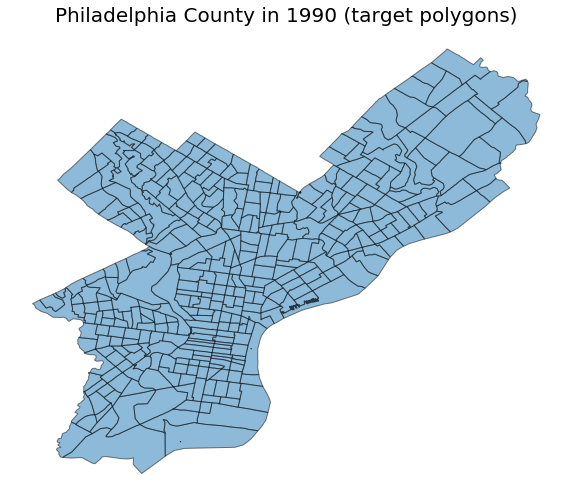

In [9]:
phili_1990 = gdf_1990[gdf_1990.geoid.str[0:5] == '42101']
ax = phili_1990.plot(figsize = (10,10), alpha = 0.5, edgecolor = 'black')
ax.set_title("Philadelphia County in 1990 (target polygons)", fontsize = 20)
plt.axis('off')

(-75.29646379999998, -74.9392762, 39.8523232, 40.1512988)

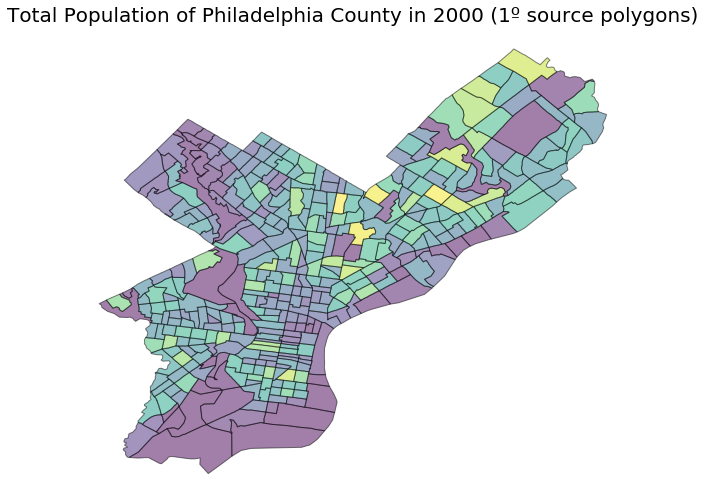

In [10]:
ax = full_phili_2000.plot(column = 'n_total_pop', figsize = (10,10), alpha = 0.5, edgecolor = 'black')
ax.set_title("Total Population of Philadelphia County in 2000 (1º source polygons)", fontsize = 20)
plt.axis('off')

(-75.29649115, -74.93953785, 39.85345459999999, 40.1515414)

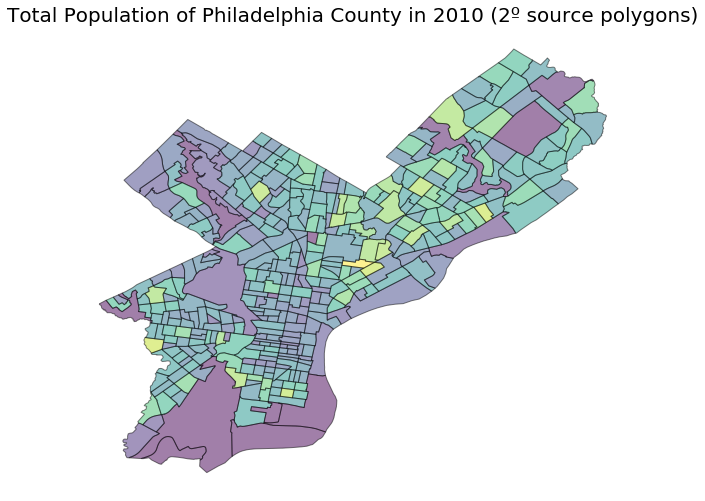

In [11]:
ax = full_phili_2010.plot(column = 'n_total_pop', figsize = (10,10), alpha = 0.5, edgecolor = 'black')
ax.set_title("Total Population of Philadelphia County in 2010 (2º source polygons)", fontsize = 20)
plt.axis('off')

**Although these maps look similar to each other, they actually do not represent the same set of polygons. There are some differences if we look closer.** This is confirmed as the number of tracts of each year is different:

In [12]:
print('N. of tracts in 1990 (target): {} \nN. of tracts in 2000 (source): {} \nN. of tracts in 2010 (source): {}'.format(len(phili_1990), len(full_phili_2000), len(full_phili_2010)))

N. of tracts in 1990 (target): 367 
N. of tracts in 2000 (source): 381 
N. of tracts in 2010 (source): 384


Since we'd like to harmonize different set of tracts, we need to make sure that all input are in the same Coordinate Reference System (CRS):

In [13]:
phili_1990.crs = full_phili_2000.crs = full_phili_2010.crs = {'init': 'epsg:4326'}

### Creating a list of all the GeoDataFrames

The input of the `harmonize` function is a list of GeoDataFrame where it is present both target dataset and all source datasets. All the variables that are going to harmonized should have the same name  among all source datasets. We call this set a *community*.

In [14]:
raw_community = [phili_1990, full_phili_2000, full_phili_2010]

# Harmonizing the geodataframes with different methods 

In [15]:
from tobler import harmonize
help(harmonize)

Help on function harmonize in module tobler.harmonize:

harmonize(raw_community, target_year_of_reference, weights_method='area', extensive_variables=[], intensive_variables=[], allocate_total=True, raster=None, codes=[21, 22, 23, 24], force_crs_match=True)
    Harmonize Multiples GeoData Sources with different approaches
    
    Parameters
    ----------
    
    raw_community : list
        Multiple GeoDataFrames given by a list (see (1) in Notes).
    
    target_year_of_reference : string
        The target year that represents the bondaries of all datasets generated in the harmonization. Could be, for example '2010'.
        
    weights_method : string
        The method that the harmonization will be conducted. This can be set to:
            "area"                          : harmonization according to area weights.
            "land_type_area"                : harmonization according to the Land Types according to National Land Cover Data (NLCD)  considered 'populated' areas.


## Area Interpolation Method

In [16]:
t0 = time.time()
harmonized_area = harmonize(raw_community,
                            target_year_of_reference = '1990',
                            extensive_variables = ['n_total_pop', 'n_white_under_15'],
                            intensive_variables = ['p_white_under_15'],
                            weights_method = 'area')
t1 = time.time()
print('Time taken (in seconds): {}'.format(t1 - t0))

Starting to Harmonize the year of 2000...
nan values in variable: p_white_under_15, replacing with 0.0
Harmonizing extensive variable n_total_pop of the year 2000.
Harmonizing extensive variable n_white_under_15 of the year 2000.
Harmonizing intensive variable p_white_under_15 of the year 2000.
Starting to Harmonize the year of 2010...
nan values in variable: p_white_under_15, replacing with 0.0
Harmonizing extensive variable n_total_pop of the year 2010.
Harmonizing extensive variable n_white_under_15 of the year 2010.
Harmonizing intensive variable p_white_under_15 of the year 2010.
Time taken (in seconds): 1.8675305843353271


The output of the function is a **single GeoDataFrame** with all interpolated variables of all source years with the same original name but with the addition of `interpolated_` prefixes.

In [17]:
harmonized_area.head()

,geoid,geometry,year,interpolated_n_total_pop,interpolated_n_white_under_15,interpolated_p_white_under_15
0,42101000001,"POLYGON ((-75.1478 39.9486, -75.14919999999999...",2000,2692.555587,37.926295,1.316683
1,42101000002,"POLYGON ((-75.15900000000001 39.9536, -75.1594...",2000,1364.565915,6.785932,0.460593
2,42101000003,"POLYGON ((-75.17749999999999 39.9551, -75.1776...",2000,2656.200162,97.529551,3.765605
3,42101000004,"POLYGON ((-75.1782 39.9523, -75.17919999999999...",2000,4289.591198,40.594815,0.938504
4,42101000005,"POLYGON ((-75.15170000000001 39.9517, -75.152 ...",2000,1295.854409,2.704585,0.134690


## Raster Land Cover Area method: National Land Cover Dataset (NLCD)

This method is similar to the area method previously. However, instead of using the actual polygon area, it uses only the area of the polygon that are considered "inhabited" according to the land type aiming to improve the estimates. In this method the proxy for the polygon area is actually the number of considered "populated pixels".

The first step to use these functionalities is to read a file from NLCD. We chose to use the data from Pennsylvania state like in example of the GeoPySpark homepage and then download the file with these commands:

```
curl -o /tmp/NLCD2011_LC_Pennsylvania.zip "https://s3-us-west-2.amazonaws.com/prd-tnm/StagedProducts/NLCD/data/2011/landcover/states/NLCD2011_LC_Pennsylvania.zip?ORIG=513_SBDDG"

unzip -d /tmp /tmp/NLCD2011_LC_Pennsylvania.zip
```
Then in the same directory as this notebook do

```
ln -s /tmp/NLCD2011_LC_Pennsylvania.tif
```
Now, you need to specify the file path of the unzipped file that would look like something like this:

In [18]:
filepath = '~/NLCD2011_LC_Pennsylvania.tif'

Reading the raster file:

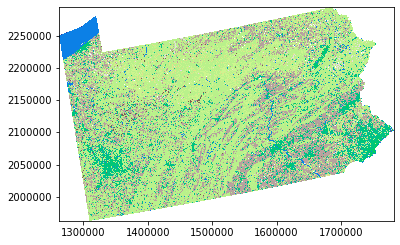

In [19]:
penn_raster = rasterio.open(filepath)
show(penn_raster, cmap='terrain')

Now, we can use the `land_type_area` option of the `weights_method`. We also need to pass the raster file with the `raster` argument. 

Other options are available for the code of the pixels types. Since this function dram inspiration from the NLCD data, the default codes are 21 (Developed, Open Space), 22 (Developed, Low Intensity), 23 (Developed, Medium Intensity) and 24 (Developed, High Intensity).

In [20]:
t0 = time.time()
harmonized_nlcd = harmonize(raw_community,
                            target_year_of_reference = '1990',
                            extensive_variables = ['n_total_pop', 'n_white_under_15'],
                            intensive_variables = ['p_white_under_15'],
                            weights_method = 'land_type_area',
                            raster = penn_raster)
t1 = time.time()
print('Time taken (in seconds): {}'.format(t1 - t0))

Starting to Harmonize the year of 2000...
Harmonizing extensive variable n_total_pop of the year 2000.
Harmonizing extensive variable n_white_under_15 of the year 2000.
Harmonizing intensive variable p_white_under_15 of the year 2000.
Starting to Harmonize the year of 2010...
Harmonizing extensive variable n_total_pop of the year 2010.
Harmonizing extensive variable n_white_under_15 of the year 2010.
Harmonizing intensive variable p_white_under_15 of the year 2010.
Time taken (in seconds): 53.07371544837952


Once again, the output of the function is a **single GeoDataFrame** with all interpolated variables of all source years with the same original name but with the addition of `interpolated_` prefixes.

In [21]:
harmonized_nlcd.head()

,geoid,geometry,year,interpolated_n_total_pop,interpolated_n_white_under_15,interpolated_p_white_under_15
0,42101000001,"POLYGON ((-75.1478 39.9486, -75.14919999999999...",2000,2666.167205,37.135867,1.307928
1,42101000002,"POLYGON ((-75.15900000000001 39.9536, -75.1594...",2000,1391.014345,6.948442,0.461179
2,42101000003,"POLYGON ((-75.17749999999999 39.9551, -75.1776...",2000,2694.413349,98.151988,3.749538
3,42101000004,"POLYGON ((-75.1782 39.9523, -75.17919999999999...",2000,4295.455408,40.858452,0.943535
4,42101000005,"POLYGON ((-75.15170000000001 39.9517, -75.152 ...",2000,1303.176395,2.765546,0.136141


# Comparing both methods in terms of the values generated for all variables

As we can see n the graphs below, both methods produce similar results.

Text(0, 0.5, 'NLCD (area)')

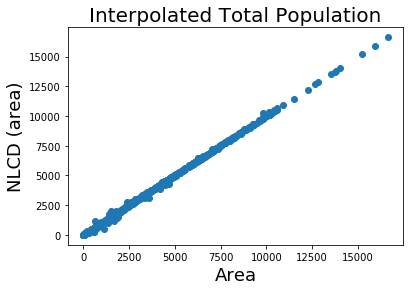

In [22]:
plt.scatter(harmonized_area.interpolated_n_total_pop, harmonized_nlcd.interpolated_n_total_pop)
plt.title('Interpolated Total Population', fontsize = 20)
plt.xlabel('Area', fontsize = 18)
plt.ylabel('NLCD (area)', fontsize = 18)

Text(0, 0.5, 'NLCD (area)')

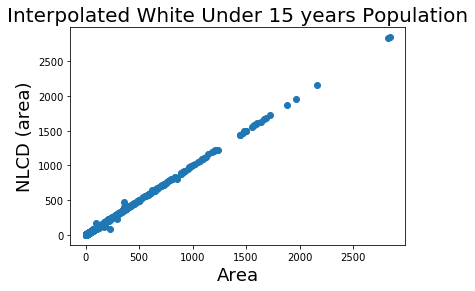

In [23]:
plt.scatter(harmonized_area.interpolated_n_white_under_15, harmonized_nlcd.interpolated_n_white_under_15)
plt.title('Interpolated White Under 15 years Population', fontsize = 20)
plt.xlabel('Area', fontsize = 18)
plt.ylabel('NLCD (area)', fontsize = 18)

Text(0, 0.5, 'NLCD (area)')

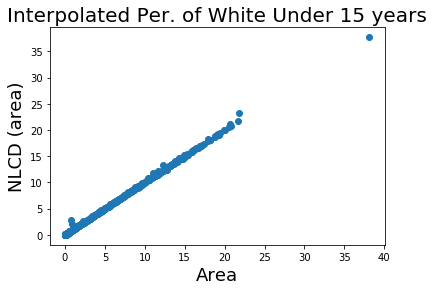

In [24]:
plt.scatter(harmonized_area.interpolated_p_white_under_15, harmonized_nlcd.interpolated_p_white_under_15)
plt.title('Interpolated Per. of White Under 15 years', fontsize = 20)
plt.xlabel('Area', fontsize = 18)
plt.ylabel('NLCD (area)', fontsize = 18)